<a href="https://colab.research.google.com/github/jonaschen16/wafermap/blob/main/WM_811k_Wafermap_show.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F14180%2F19086%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T203545Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b16281eafb86a6324bb47c28cf60618a771adc9227926be72b4c9d09bea7a2188167d74363e01b7972a596b1610556e46661a7ad8fba479d2c1d6e73a2ecb712ac650814fd5cb67745e8c3f14e65f0505d87333bc908d88d2de679053c756349073fcbbd7df982fde987d5b0873923f23517368ffe9c51cd8b4d2f97045e7044b9c4f47fe95db72b094b7f8c3c49951fda2e8debd805f186bb942d6f43045f2a93883019c8ec9cf36ab8b87f7fe1d9293eea0721fe89d27b2933252f5135d549cee6cbce91a6667a7aab420712a0858ce01a8e9e371a976264217ef61c2ae6003997ff65c6cc13ccf02126bfa370ca6da8f2f7ab9d45fccf6a2d4b761891047'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 156686283 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


Shows how machine learning is used in the semiconductor industry.

Purpose: Automatically identify failure patterns in the wafer map instead of manually. Through this, the yield of the manufacturing process in semiconductor production is improved.

input: kaggle WM-811K dataset

Model: one vs one multi-class classification model image detection system (splitting data with multiple classes into data with different classes and learning it with a binary classifier)

output: Failure pattern labels

In [2]:
# Load library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


Data selection & preprocessing: Consider which data is usable, which data is lost, and which data can be deleted. Additionally, the selected data is organized through formatting, cleaning, and sampling.

- Data summary
- Target distribution
- Missing value check
- Others

In [4]:
!pwd

/content


In [3]:
# Data summary

df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- This dataset consists of information such as dieSize, lotName, waferIndex, and 811457 wafermaps.
- Both the training set and the test set have already been classified by experts. However, here it was ignored and redesigned.

In [ ]:
# list defect pattern

print('listing...')
n = np.size(df, axis=0)
with open('map_defect_list.csv', 'w') as file1:
    file1.write('map#,defect\n')
    for i in range(0, n):
        pattern = 0

        if 'none' in df['failureType'][i] or len(df['failureType'][i]) == 0:
            pattern = 0
        else:
            #print(i)
            file1.write(str(i))
            for ft in df['failureType'][i]:
            #    print(',', ft[0])
                file1.write(',' + ft[0])
            file1.write('\n')


print('done')





listing...
done


In [5]:
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
788671,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1465.0,lot46616,6.0,[[Test]],[[none]]
548236,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34333,23.0,[],[]
124682,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",980.0,lot8268,13.0,[],[]
678186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot42136,21.0,[[Test]],[[none]]
730652,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot44261,3.0,[[Test]],[[none]]


In [ ]:
# Target distribution

df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- This dataset was collected from 47543 real lots (set of 25 wafers) in the fab.
- However, there are 47543*25=1557325 wafers in 47543 lots, which is larger than the number of wafer maps of 811457. -> Let’s take a look at the data..

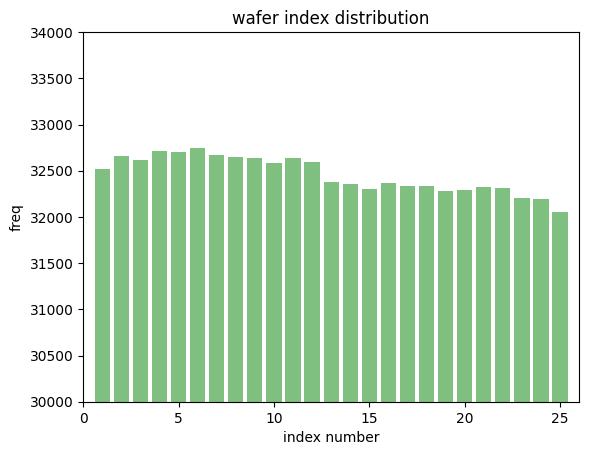

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='green', align='center', alpha=0.5)
plt.title("wafer index distribution")
plt.xlabel("index number")
plt.ylabel("freq")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

- Extract the number of unique values from an array using np.unique and return_counts=True.
- The index and its number are contained in uni_Index[0] and [1], respectively, and this is drawn as a bar graph.

- As a result, you can see that there are not 25 wafer maps in each lot. This may be due to sensor failure or other unknown problems.
- In our classification, there is no need for the wafer index feature, just drop the variable.

In [7]:
df=df.drop(['waferIndex'], axis=1)

- You can see that the die sizes are all different.
- So, let’s create a new variable ‘waferMapDim’ and use it.

In [8]:
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
546579,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34191,[],[],"(49, 39)"
590661,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,...",515.0,lot36882,[],[],"(25, 27)"
386763,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot23167,[],[],"(41, 42)"
393468,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot23598,[],[],"(40, 40)"
151302,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot9768,[],[],"(64, 71)"


In [9]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [10]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

- When I saw that the min and max values of the dimensions of the wafer map were different, I could see that the sizes were all different.
- It was also found that there were 632 different sizes.

Now it’s time to check for missing data.

- Missing values may result in useless values.
- Checking missing values is very important in the data preprocessing process.
- Since we are only interested in wafers with patterns in the first place, we can delete data without a failure type label.

In [11]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [12]:
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
233847,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4553.0,lot14632,[],[],"(73, 79)",[],[]
749100,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1,...",498.0,lot45008,[[Training]],[[none]],"(27, 25)",8,0
669946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot41704,[],[],"(32, 29)",[],[]
501170,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot31158,[],[],"(32, 29)",[],[]
485819,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",710.0,lot30079,[],[],"(32, 29)",[],[]


In [13]:
tol_wafers=df.shape[0] # return number of rows
tol_wafers

811457

In [14]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] # Create a new data frame
df_withlabel = df_withlabel.reset_index() # Reset the index of the data frame created earlier
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)] # Create a new data frame
df_withpattern = df_withpattern.reset_index() # Reset data frame index
df_nonpattern = df[(df['failureNum']==8)] # Create a new data frame
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] # Returns the number of rows in each data frame

(172950, 25519, 147431)

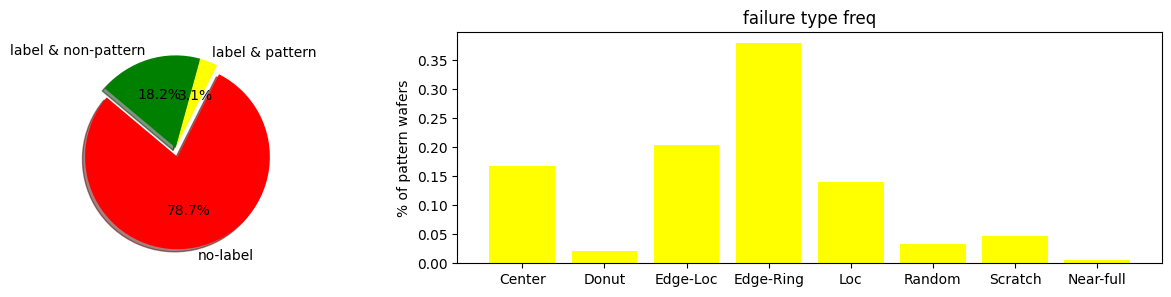

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
figure = plt.figure(figsize=(15,3))
gridspec = gridspec.GridSpec(1, 2, width_ratios=[1,2])
ax1 = plt.subplot(gridspec[0])
ax2 = plt.subplot(gridspec[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['red', 'yellow', 'green']
explode = (0.1, 0, 0)
labels = ['no-label', 'label & pattern', 'label & non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2=['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='yellow', align='center', alpha=1)
ax2.set_title("failure type freq")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- Looking at the results, 172950 wafers are labeled. However, the remaining 78.7% of wafers were not labeled.
- Among the labeled wafers, 25519 wafers (3.1%) have a failure pattern, but the remaining 147431 wafers are still intact. In the end, I think we should only focus on 25519...
- There are various failure types

- I think I need to do some data visualization to see the data at a glance.
- Let's pick a few of the labeled ones and take a look.

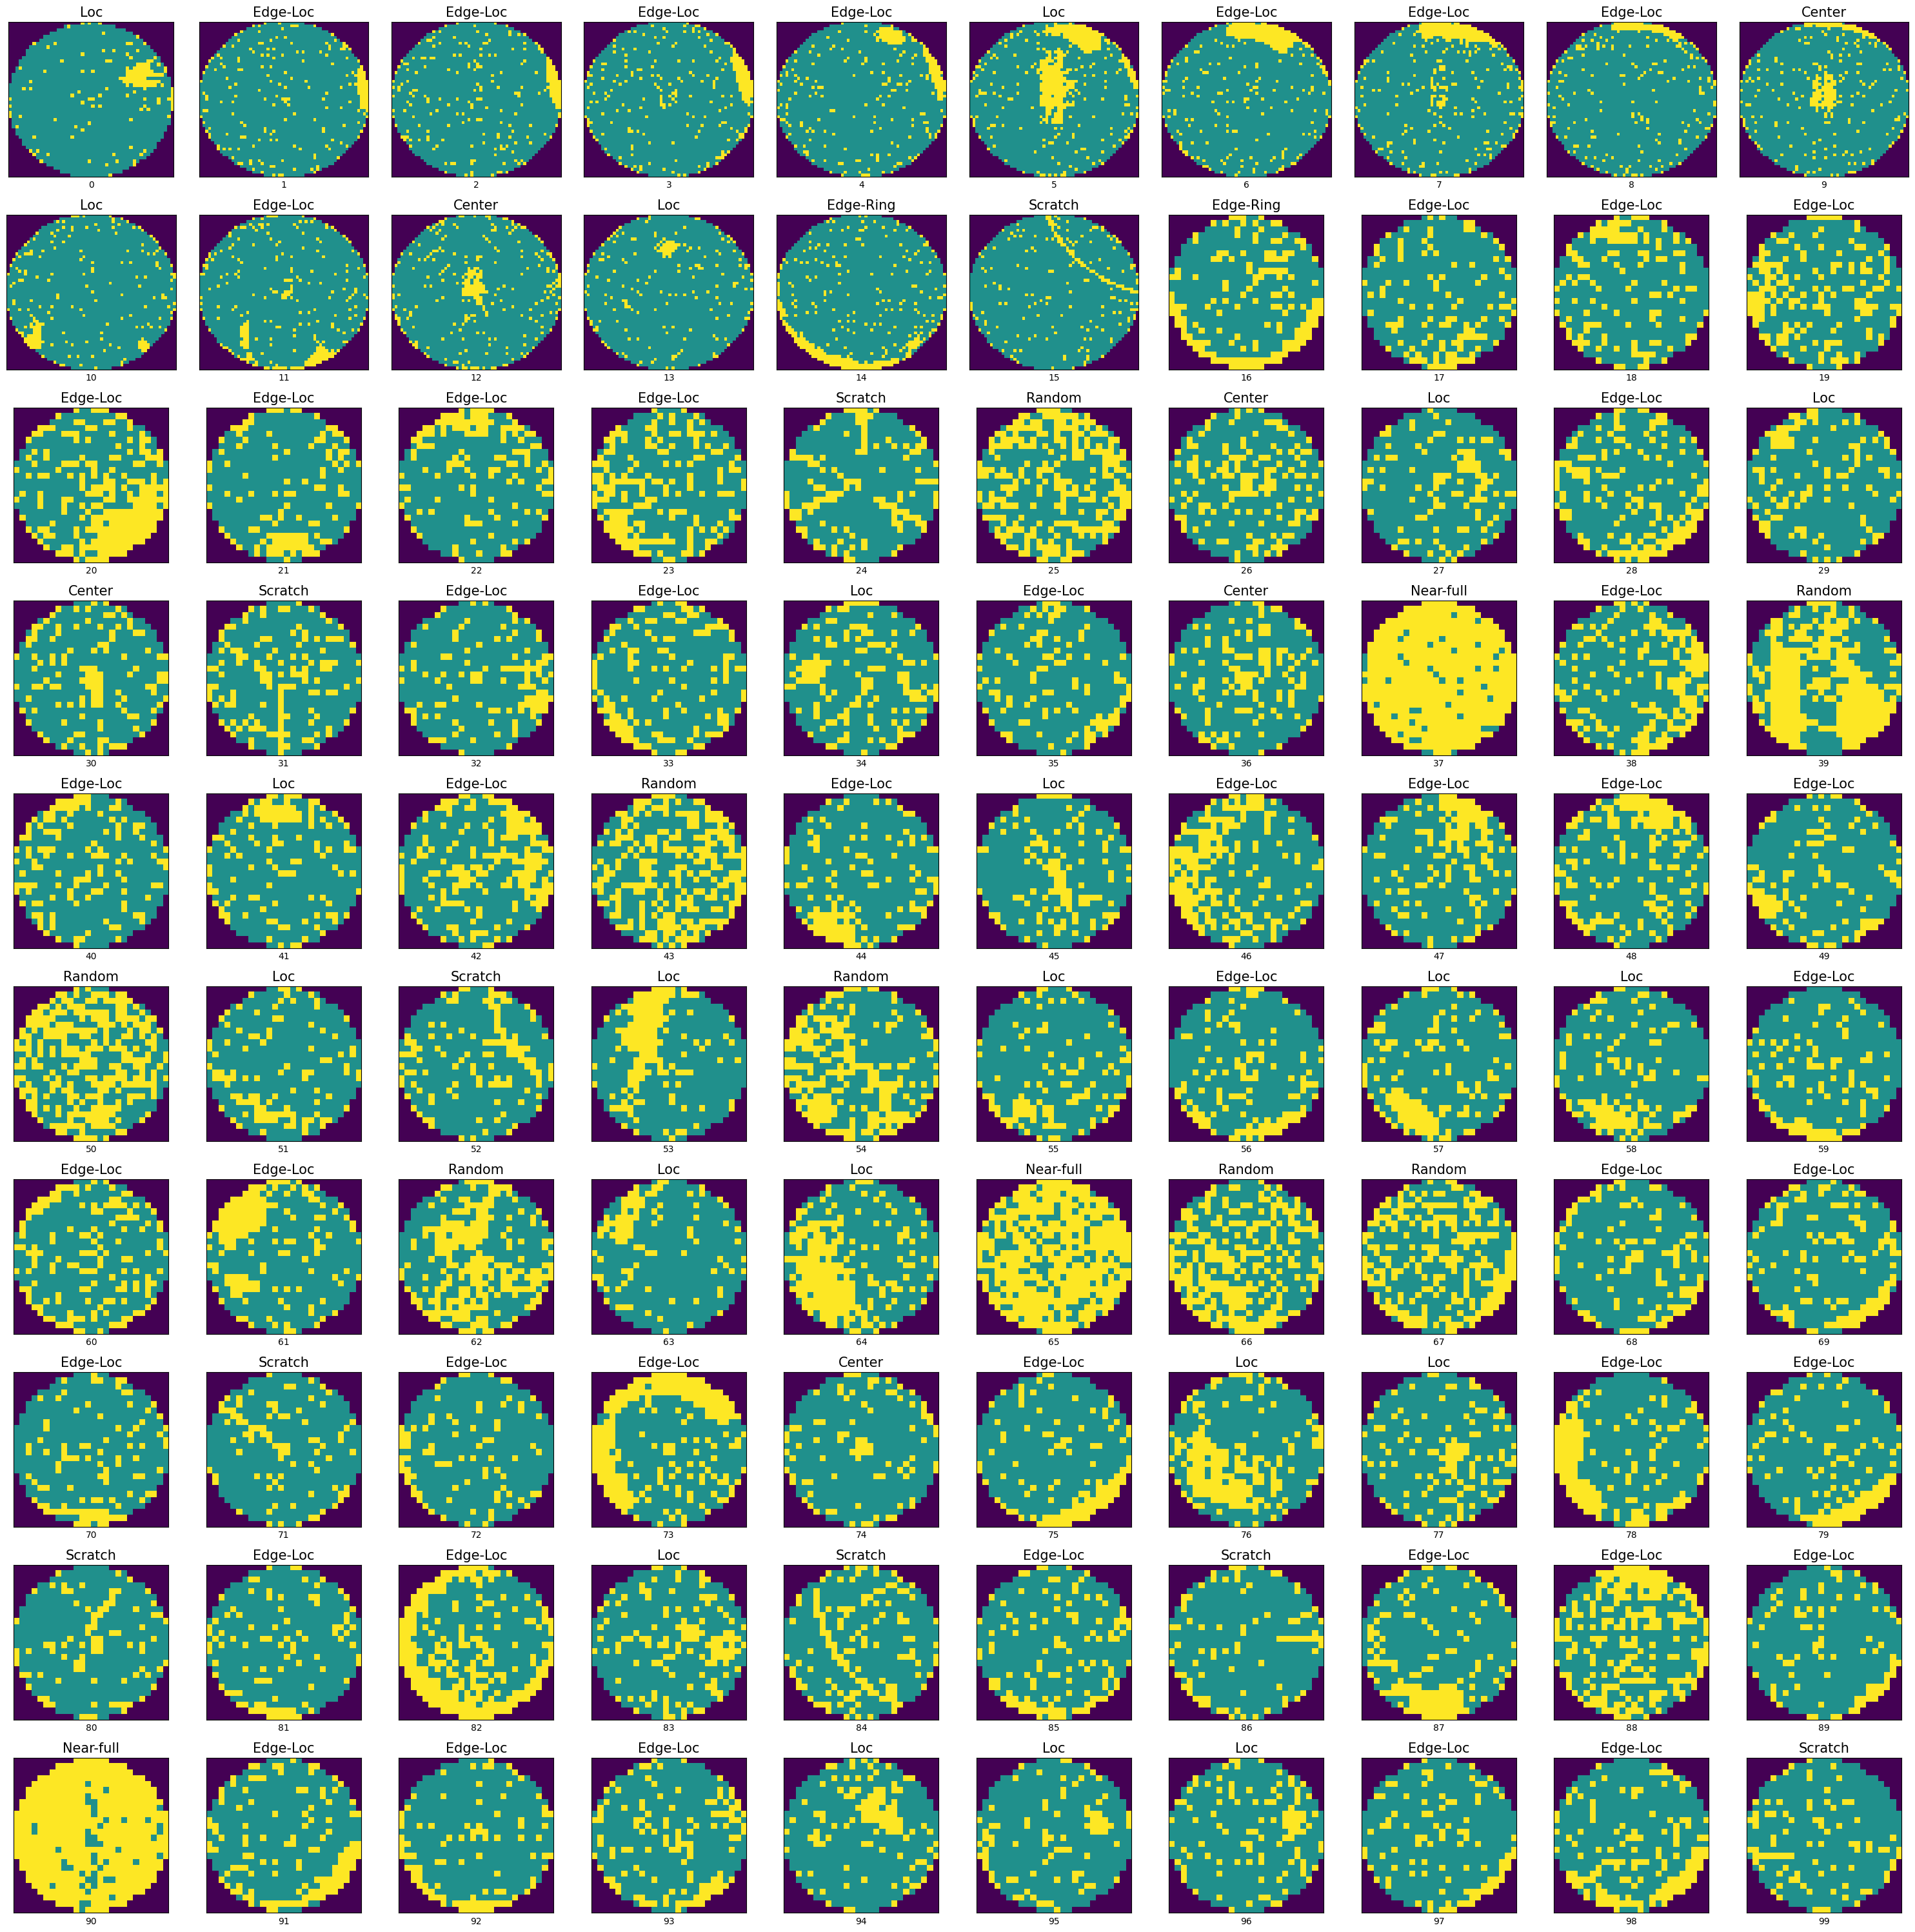

In [16]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

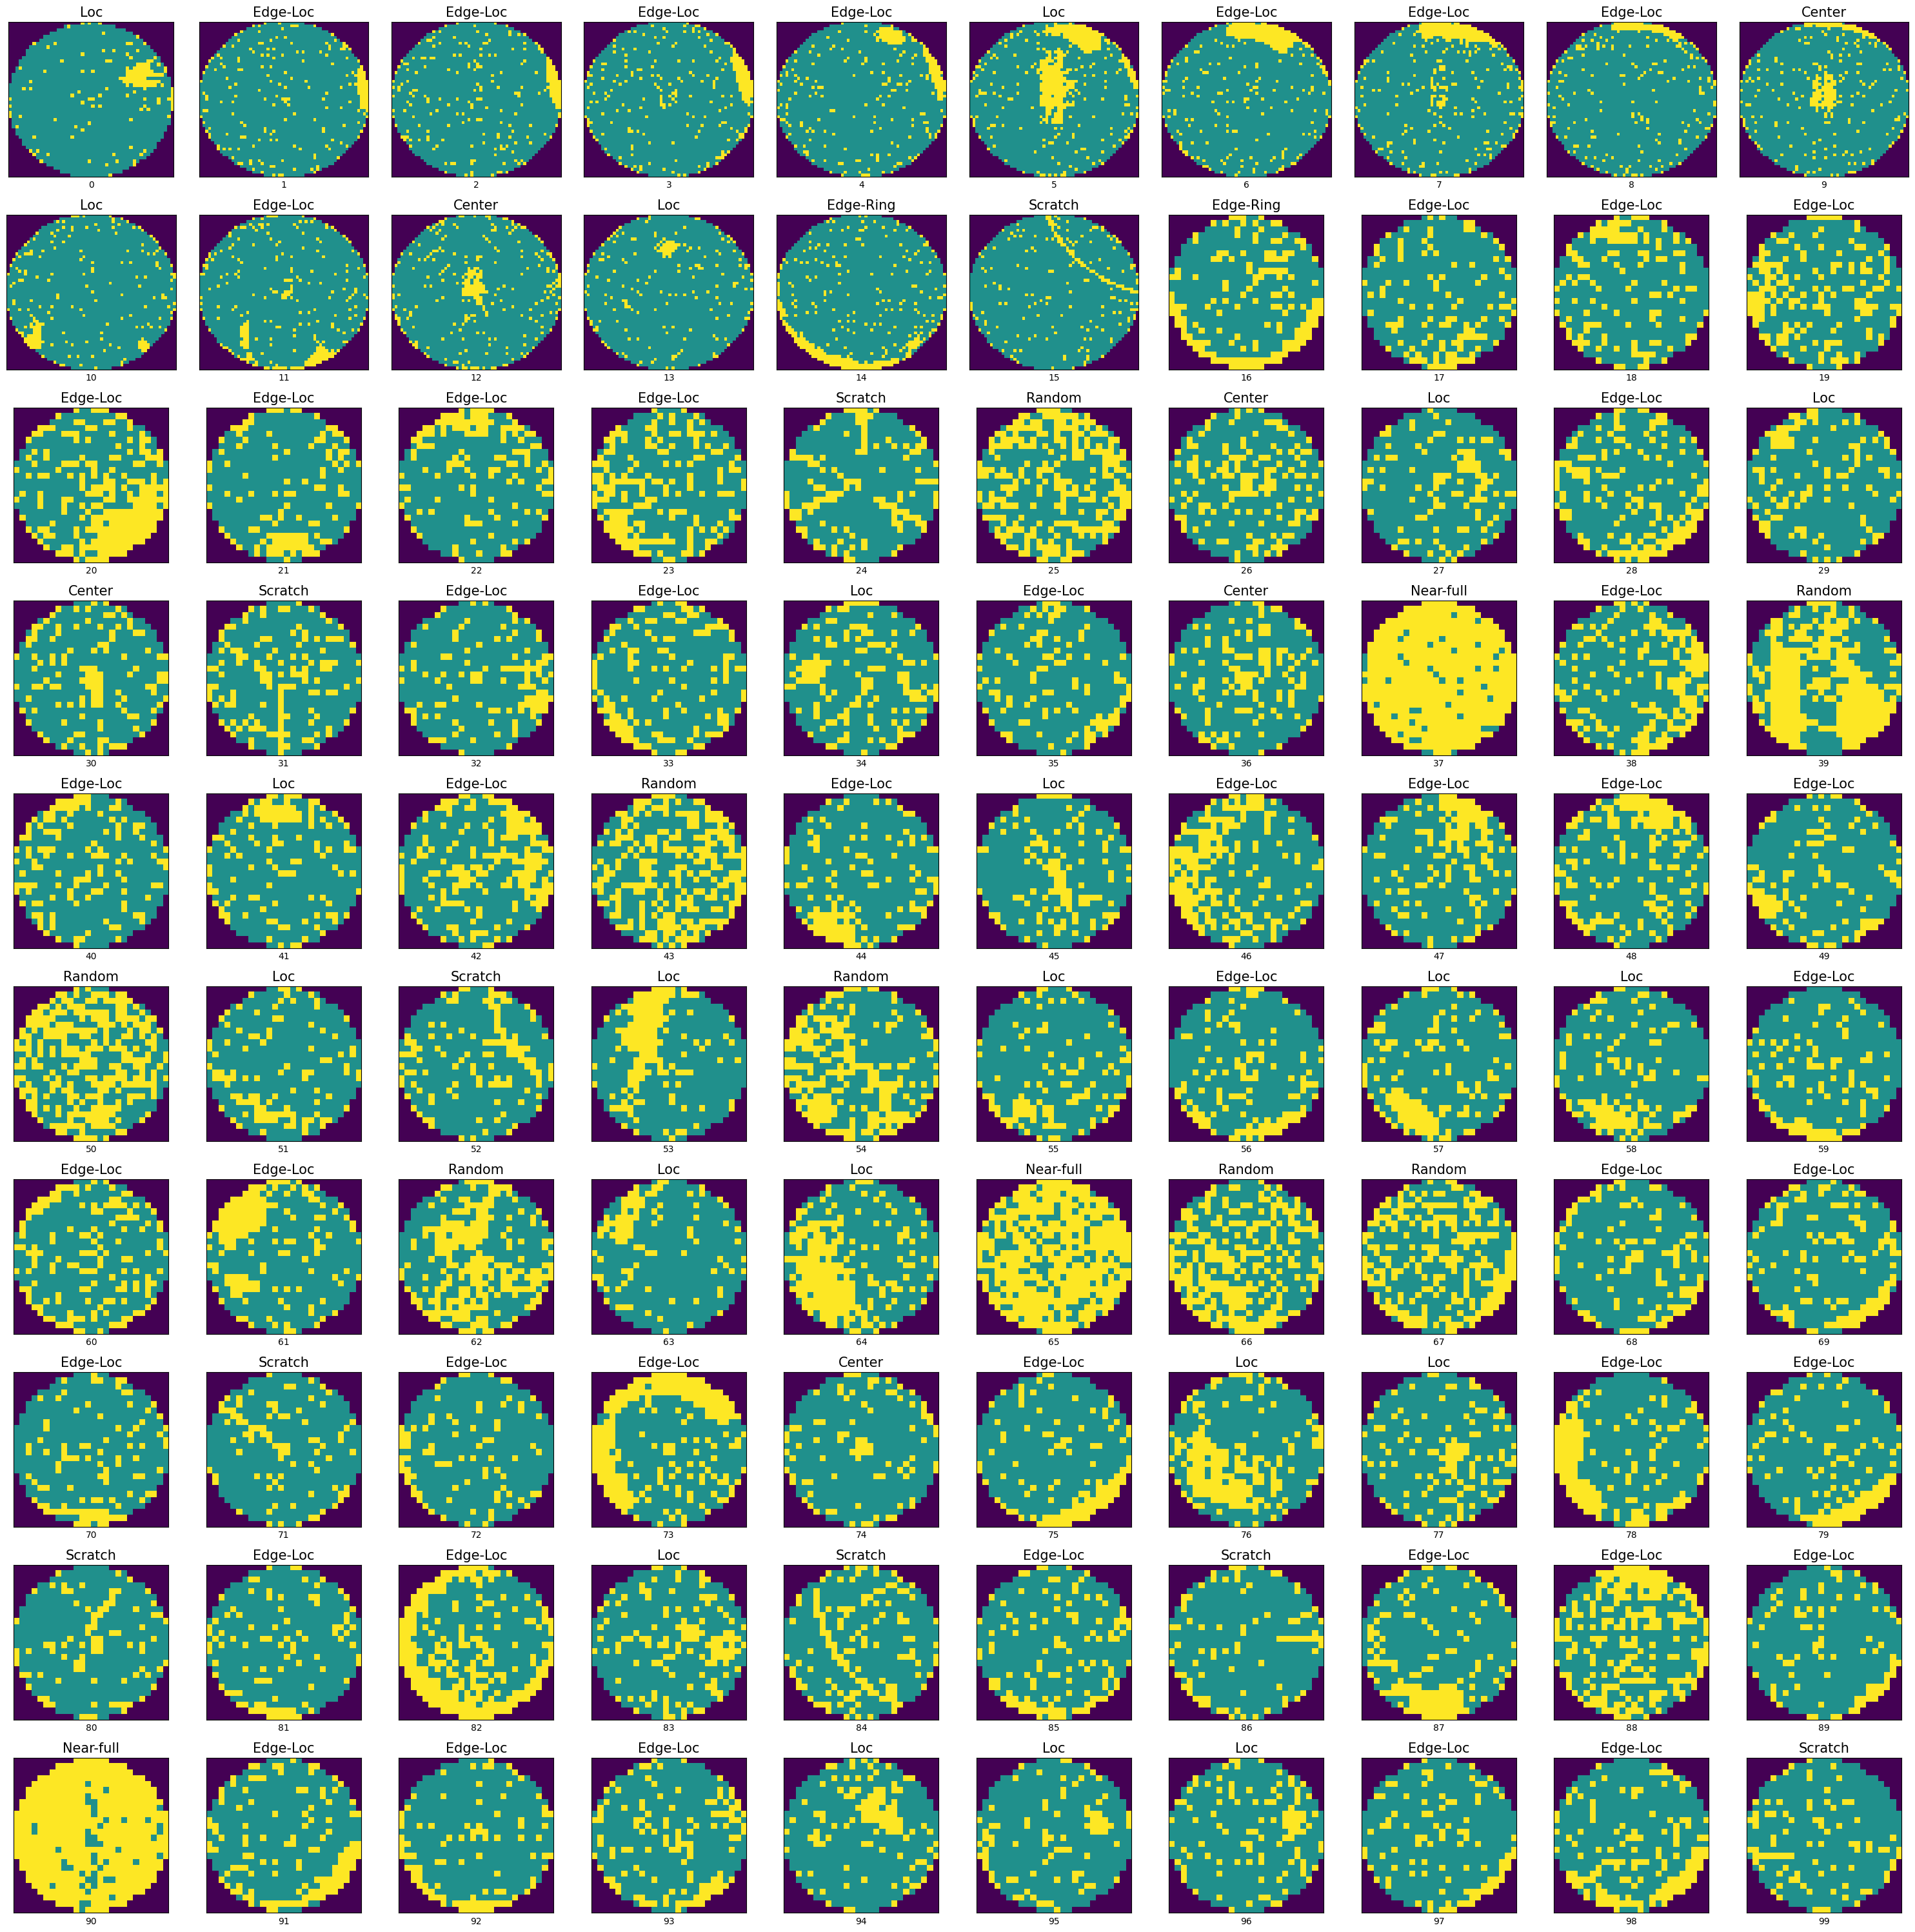

In [17]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

- Appears in 6 types: Log, Edge-Loc, Center, Near-full, Scratch, and Random.

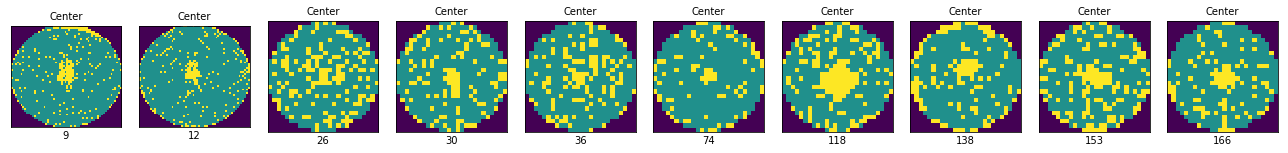

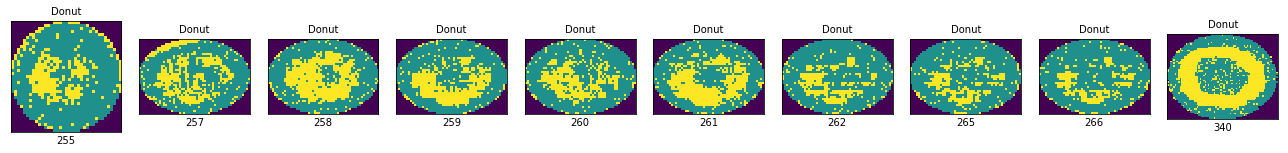

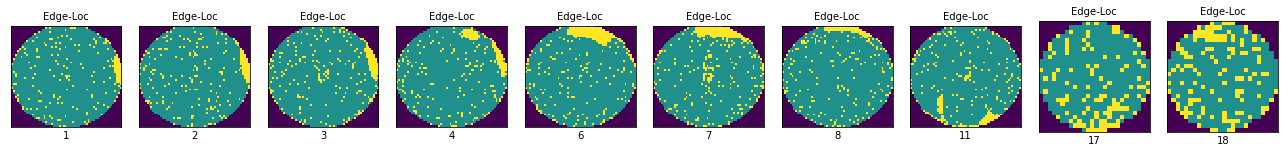

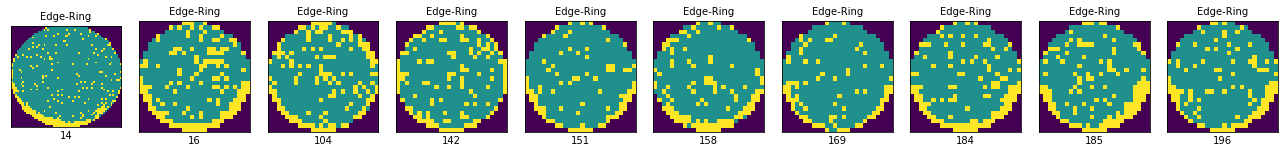

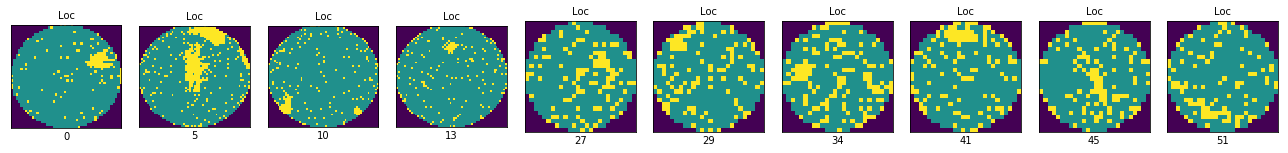

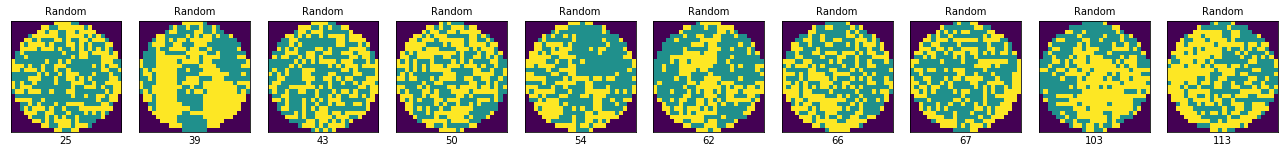

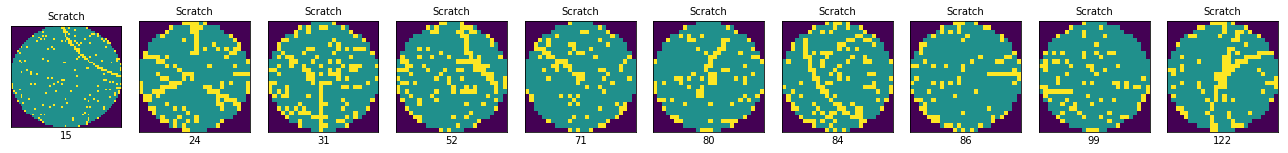

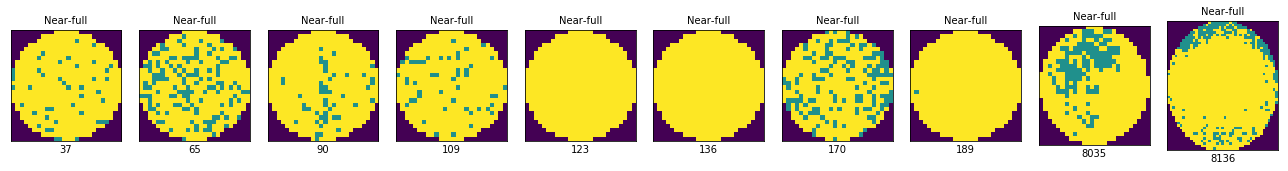

In [ ]:
x=[0,1,2,3,4,5,6,7]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in x:
    fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
    ax=ax.ravel(order='C') # ravel changes multi-dimensional array to 1-dimensional, C is default
    for j in [i]:
        img=df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for k in range(10):
            ax[k].imshow(img[img.index[k]])
            ax[k].set_title(df_withpattern.failureType[img.index[k]][0][0], fontsize=10)
            ax[k].set_xlabel(df_withpattern.index[img.index[k]], fontsize=10)
            ax[k].set_xticks([])
            ax[k].set_yticks([])
    plt.tight_layout()
    plt.show()

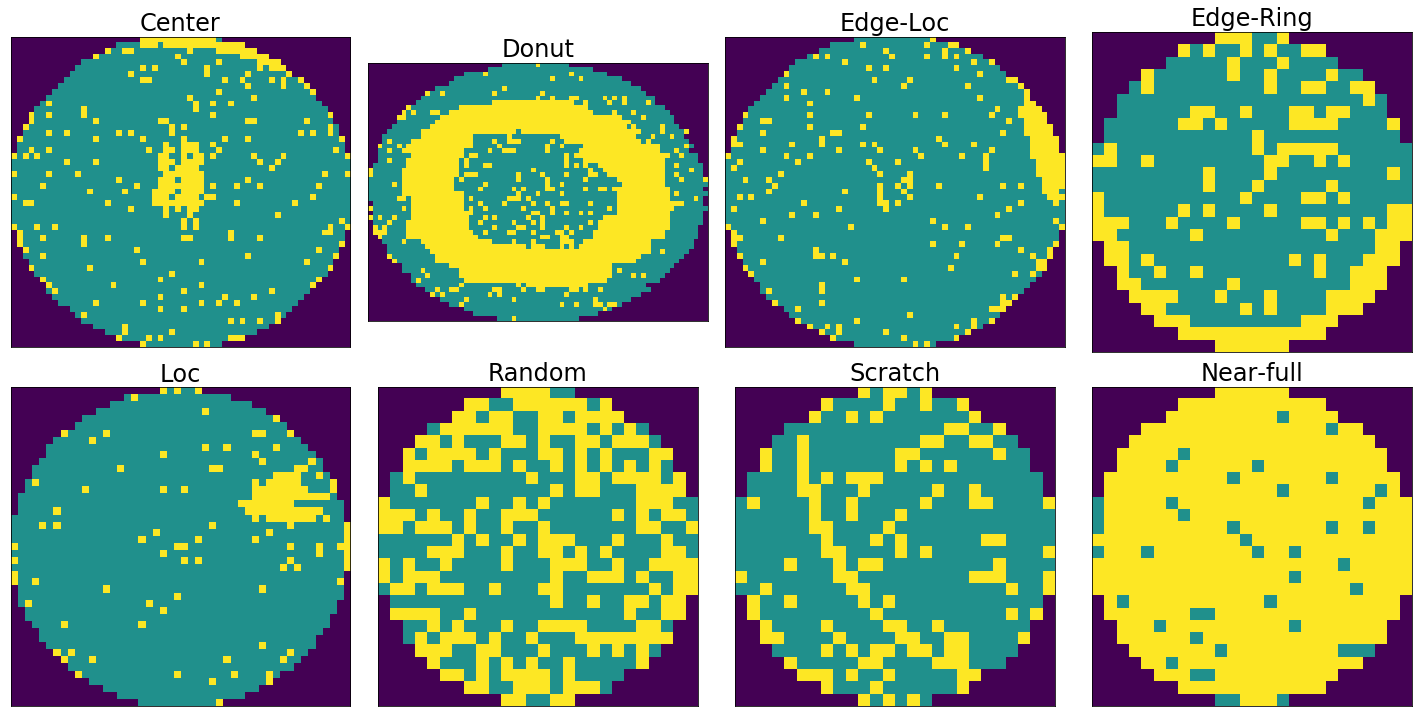

In [ ]:
x=[9, 340, 3, 16, 0, 25, 84, 37]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))
ax=ax.ravel(order='C')
for i in range(8):
    img=df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

Now let's transform the data.
- Data transformation: It seems that a process of preprocessing data is necessary for machine learning.

In [ ]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

- Let’s divide the wafermap into 13 parts and calculate the density of defects.
- Depending on the failure pattern, the distribution of density will be different. Because the center type will have high density in the center.

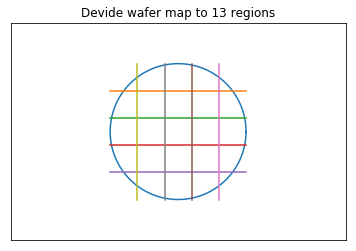

In [ ]:
an=np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4,4,-4,4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])

plt.title("Devide wafer map to 13 regions")
plt.xticks([]) # 축 없애기
plt.yticks([])
plt.show()

In [ ]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)

    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]

    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [ ]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

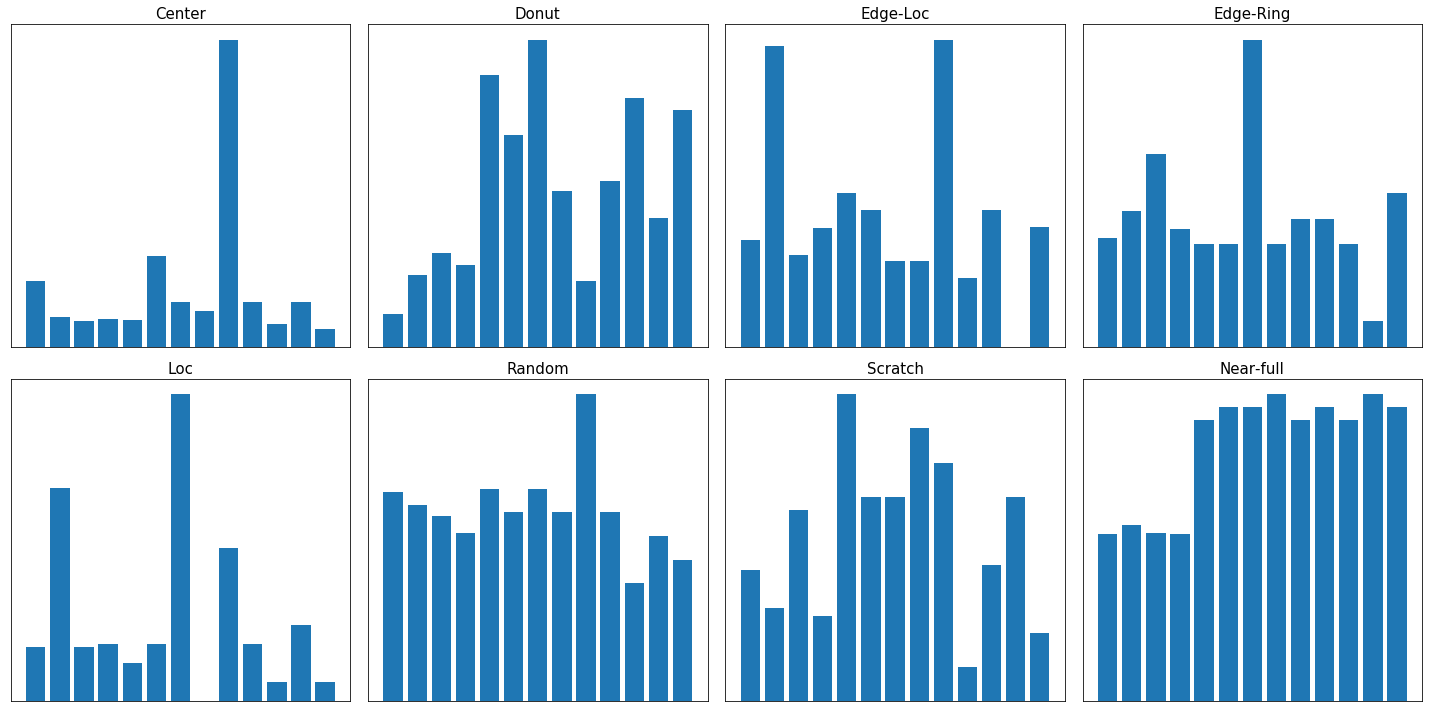

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

- Graph expressing the density of failure types
- Because density-based graphs can make classification easier.

- Based on Radon transformation, the projected wafer map can be expressed in 2D.

In [ ]:
def change_val(img):
    img[img==1] =0
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

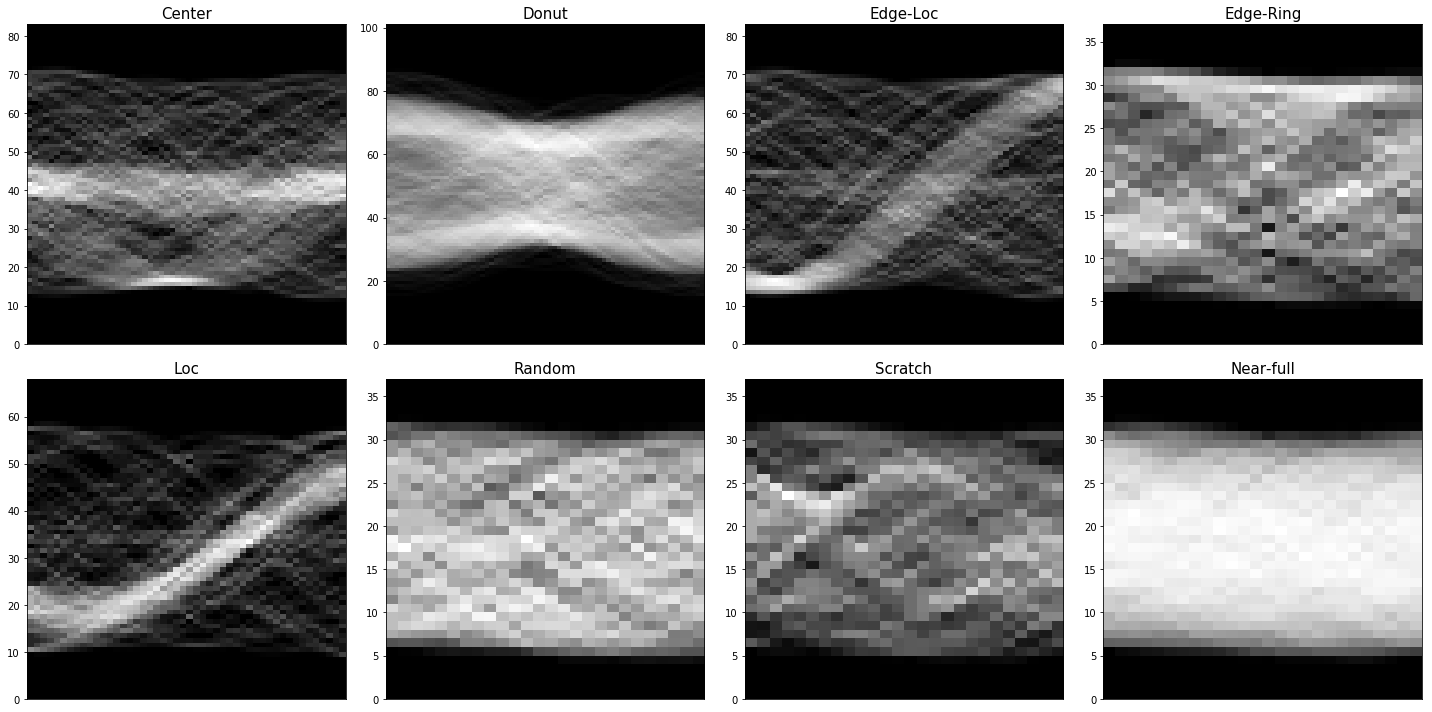

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)

    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show()

- This is the result of Radon transformation for each failure type.
- However, since the wafer sizes are all different, it is difficult to make a specific determination. Therefore, we will utilize cubic interpolation to obtain fixed values for each row mean and standard deviation in the Radon transformation. And the values are fixed to 20, respectively.
- As a result, the dimension becomes 40.

In [ ]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

In [ ]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

KeyboardInterrupt: 

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])
    ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show()

- Identifying the most salient areas is ultimately like filtering out noise.
- Therefore, we will pick the maximum region of the most salient part and use the region labeling algorithm.
- From these salient areas, we will extract geometric characteristics such as area, perimeter, major axis length, minor axis length, solidity, eccentricity, etc.

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]

    zero_img[np.where(img_labels==no_region)] = 2
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show()

In [ ]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)

    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1

    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter

    prop_cent = prop[no_region].local_centroid
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])

    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter
    prop_ecc = prop[no_region].eccentricity
    prop_solidity = prop[no_region].solidity

    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [ ]:
df_withpattern_copy.fea_geom[340] #donut

- Density-based: 13
- Radon-based: 40
- Geometry base: 6
- Total 59

In [ ]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [ ]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

- Since you are free to decide which algorithm to use, we will use SVM.
- Usually, SVM is used in supervised learning for pattern recognition and data analysis. Classification and regression analysis are the main functions.

In [ ]:
import theano
from theano import tensor as T
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

In [ ]:
# ---multicalss classification ---#
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)
train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train[:100]: ", y_train[:100])

- Looking at this, you can see that in the case of training, the accuracy was 80.3699%.
- In case of testing, 79.04%.

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

- You can probably improve the accuracy further by modifying the algorithm or combining different models like an ensemble!